In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import json
import scipy
import os

import discrete_CRISPR_methods as ds

In [2]:
params = { #parameters relevant for the equations
    "Nh":             100,
    "N0":             100,
    "R0":             1.5,
    "M":                1, #Also L
    "D":                3, #Unused
    "mu":             0.1, 
    "gamma_shape":     20, 
    "Np":              10, #Number of Cas Protein
    "dc":               5, #Required number of complexes to activate defence
    "h":               10, #coordination coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    4,
    "dx":                         1,
    "t0":                         0, 
    "tf":                      1000,
    "dt":                       0.1,
    "noise_mean":                 0,
    "noise_std":                0.1,
    "initial_mean":           [0,0],
    "initial_var":                5,
    "n_step_prior":               5,
    "folder_name":  "simulation#11/",
}

In [3]:
x_range = sim_params["xdomain"] #Initialize the spaces
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size], dtype=int)
n = np.zeros([x_size, x_size], dtype=int) 
nh = np.zeros([x_size, x_size], dtype=int) #nh(x,t) = Nh*h(x,t) there should be a total of Nh*M elements 
coordmap = np.meshgrid(x_linspace, x_linspace) #coordmap is kinda stupid since we are not in any real space
c = nh.copy() # c is unused (supposed to be coverage)

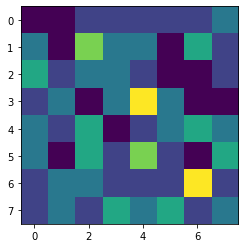

In [4]:
n0 = np.zeros(n.size, dtype=int) #Initial value of n0, initialized with a gaussian distributed

N0 = int(params["N0"])
initial_position = sim_params["initial_mean"]
initial_var = sim_params["initial_var"]

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(N0):
    index = np.random.choice(n.size, p=p0) #Should really have a better way of doing this, this is extremely slow: maybe MPI?
    n0[index] += 1

n = copy.deepcopy(n0.reshape(n.shape)) #Make a deepcopy to seperate the two functions
plt.figure()
plt.imshow(n)

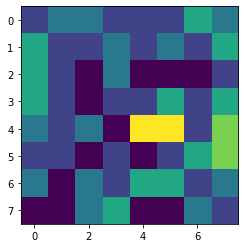

In [5]:
nh0 = np.zeros(nh.size, dtype=int) #Similarly, this is the initial value for nh

Nh = int(params["Nh"])
M = int(params["M"])

initial_position = sim_params["initial_mean"]
initial_var = 10*sim_params["initial_var"] #just 10 times the variance of n0, maybe change this?

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(Nh*M):
    index = np.random.choice(nh.size, p=p0) #similarly, this is really slow
    nh0[index] += 1

nh = copy.deepcopy(nh0.reshape(nh.shape))
plt.figure()
plt.imshow(nh)

In [8]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape) # In time 

t_start = sim_params["t0"] #Time parameters
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = [] #Store the frames as gifs
frames_nh = []
frames_f = []
times = []

N = []

for t in np.arange(t_start, t_stop, t_step):

    f = ds.fitness_controlled(n, nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    current_N = np.sum(n)
    current_Nh = np.sum(nh)
    
    frames_nh.append([nh])
    frames_f.append([f])
    frames_n.append([n])
    times.append([t])
    N.append([current_N])

    n_step_prior = sim_params["n_step_prior"]

    if (current_N > current_Nh/2) and (t > (t_stop - t_start)/2):
        print("Population Reset")
        break

    if (current_N == 0):
        print("Population Death")
        break

Population Death


In [ ]:
sim_params["folder_name"] = "Test"
os.mkdir(sim_params["folder_name"])
os.chdir(sim_params["folder_name"])

ds.write2json("", params, sim_params)
ds.makeGif(frames_n, "n_simulation")
ds.makeGif(frames_nh, "nh_simulation")
ds.makeGif(frames_f, "f_simulation")

os.chdir("../")

In [7]:
def update(n, nh):

    f = ds.fitness(nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update n
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    return n, nh

In [9]:
def fitness_spacers(nh, params, sim_params):
    R0 = params["R0"]
    M = params["M"]
    Nh = params["Nh"]
    Np = params["Np"]

    h = nh/Nh
    P0 = (1-ds.coverage(h, params, sim_params))**M
    P1 = 1-P0

    sum = 0
    for d in range(Np):
        sum = sum + P1*(1-alpha(d))*q(d, nh.shape, params)

    P_infection = P0 + sum 
    eff_R0 = P_infection*R0
    mask = (eff_R0 <= 0)
    ma_eff_R0 = ma.masked_array(eff_R0, mask = mask)
    res = ma.log(ma_eff_R0)
    return res

def alpha(d, params):
    dc = params["dc"]
    h = params["h"]

    return d**h/(d**h + dc**h)

def q(d, shape, params):
    Np = params["Np"]
    M = params["M"]
    return np.random.binomial(d, 1/M, shape)

In [14]:
R0 = params["R0"]
M = params["M"]
Nh = params["Nh"]
Np = params["Np"]

h = nh/Nh
P0 = (1-ds.coverage(h, params, sim_params))**M
P1 = 1-P0

P_tt = 0
for d in range(1,Np):
    P_tt = P_tt + P1*(1-alpha(d, params))*q(d, nh.shape, params)

P_inf = P0 + P_tt 

In [16]:
P_inf

array([[1.12259353, 1.24518707, 1.24518707, 1.12259353, 1.12259353,
        1.12259353, 1.3677806 , 1.24518707],
       [1.3677806 , 1.12259353, 1.12259353, 1.24518707, 1.12259353,
        1.24518707, 1.12259353, 1.3677806 ],
       [1.3677806 , 1.12259353, 1.        , 1.24518707, 1.        ,
        1.        , 1.        , 1.12259353],
       [1.3677806 , 1.12259353, 1.        , 1.12259353, 1.12259353,
        1.3677806 , 1.12259353, 1.3677806 ],
       [1.24518707, 1.12259353, 1.24518707, 1.        , 1.61296767,
        1.61296767, 1.12259353, 1.49037414],
       [1.12259353, 1.12259353, 1.        , 1.12259353, 1.        ,
        1.12259353, 1.3677806 , 1.49037414],
       [1.24518707, 1.        , 1.24518707, 1.12259353, 1.3677806 ,
        1.3677806 , 1.12259353, 1.24518707],
       [1.        , 1.        , 1.24518707, 1.3677806 , 1.        ,
        1.        , 1.24518707, 1.12259353]])

In [31]:
P_infection

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.48936868],
       [12.37782184,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.36702651,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ]])

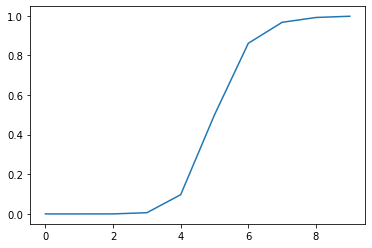

In [61]:
plt.figure()
plt.plot(alpha(d, params))

5

In [74]:
jump = np.zeros(2)
mean = 2*dx
shape_param = 20
theta = mean/shape_param

for i in range(2):
    angle = np.random.uniform(0, 2*np.pi)
    jump = jump + np.random.gamma(shape_param, theta)*np.array([np.cos(angle), np.sin(angle)])

print(jump)

[-0.89570858 -0.68682996]


3.483918557322842